<a href="https://colab.research.google.com/github/Louizaait/Seasonal-Quantile-Forecasting-of-Solar-Photovoltaic-Power-using-Q-CNN-GRU-/blob/main/Q_CNN_GRU_(Netherlands)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Import the necessary libraries

In [1]:
%%capture
pip install pysolar pvlib properscoring

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import plotly.graph_objects as go
import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import GRU, Dense, Flatten, LSTM, Conv1D, MaxPooling1D,Input

from pysolar.solar import get_altitude, get_azimuth
from pvlib.location import Location
from pvlib.solarposition import get_solarposition
import pytz
import pvlib

from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
import tensorflow as tf
from tensorflow.keras import backend as K
import properscoring as ps
from scipy import stats
from scipy.stats import binom

In [3]:

!wget https://zenodo.org/record/6906504/files/filtered_pv_power_measurements_ac.csv?download=1 -O filtered_ac.csv
#!wget https://zenodo.org/record/6906504/files/filtered_pv_power_measurements_sc.csv?download=1 -O filtered_sc.csv
# Load and preprocess data

--2025-01-10 13:12:48--  https://zenodo.org/record/6906504/files/filtered_pv_power_measurements_ac.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/6906504/files/filtered_pv_power_measurements_ac.csv [following]
--2025-01-10 13:12:49--  https://zenodo.org/records/6906504/files/filtered_pv_power_measurements_ac.csv
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2985408767 (2.8G) [text/plain]
Saving to: ‘filtered_ac.csv’

filtered_ac.csv     100%[===================>]   2.78G  18.1MB/s    in 2m 39s  

2025-01-10 13:15:28 (17.9 MB/s) - ‘filtered_ac.csv’ saved [2985408767/2985408767]



Data preprocessing

In [9]:
df = pd.read_csv('filtered_ac.csv')[['DateTime', 'ID003']]

# Convert 'DateTime' column to datetime format for proper time-based operations
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set 'DateTime' as the index for time series analysis
df.set_index('DateTime', inplace=True)

# Resample data to 1-hour intervals and calculate the mean for each period
df_resampled = df.resample('1h').mean()



# Fill with the same timestamp from one year ahead (next year)
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift(-2 * 365))
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift(2* 365))
# Fill with the same timestamp from three years ahead
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift(- 365))
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift( 365))
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift(3* 365))
# Calculate solar zenith angle for Bellingwolde, Netherlands
location = Location(latitude=53.1218, longitude=7.1761, tz='UTC')
solar_position = get_solarposition(df_resampled.index, latitude=location.latitude, longitude=location.longitude)

# Add the solar zenith angle to the dataframe and filter based on zenith angle < 85
df_resampled['Solar_Zenith'] = solar_position['zenith']
df_filtered = df_resampled[df_resampled['Solar_Zenith'] < 85]

# Convert power from watts to kilowatts (divide by 1000)
df3 = df_filtered['ID003']/1000

# Rename the 'ID003' column to 'Power' for clarity
df3 = df3.rename('Power')

# Reset the index to make 'DateTime' a column again (useful for further analysis/plotting)
df3 = df3.reset_index()

df3.isna().sum()




,0
DateTime,0
Power,0


In [10]:
# Plot using Plotly for interactive visualization
import plotly.express as px
fig = px.line(df3, x='DateTime', y='Power',
              title="Solar Power (W) vs Time",
              labels={'Power': 'Power (W)', 'DateTime': 'Time'},
              hover_data={'Power': True})

# Show the plot
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Power (W)",
    hovermode="x unified"
)

fig.show()


In [11]:

# Define split ranges for training, validation, and testing
train_start = "2014-01-01"
train_end = "2014-12-31"  # Train for 2014
val_start = "2015-01-01"
val_end = "2015-12-31"    # Validation for 2015
test_start = "2017-01-01"
test_end = "2017-12-31"   # Test for 2017
# Ensure DateTime column is datetime formatted
df3['DateTime'] = pd.to_datetime(df3['DateTime'])

# Data Splitting
train = df3[(df3['DateTime'] >= train_start) & (df3['DateTime'] <= train_end)].copy()
val = df3[(df3['DateTime'] >= val_start) & (df3['DateTime'] <= val_end)].copy()
test = df3[(df3['DateTime'] >= test_start) & (df3['DateTime'] <= test_end)].copy()

# Seasonal Splitting
spring = test['DateTime'].dt.month.isin([3, 4, 5])  # Spring months
summer = test['DateTime'].dt.month.isin([6, 7, 8])  # Summer months
autumn = test['DateTime'].dt.month.isin([9, 10, 11])  # Autumn months
winter = test['DateTime'].dt.month.isin([12, 1, 2])  # Winter months

spring_data = test[spring]
summer_data = test[summer]
autumn_data = test[autumn]
winter_data = test[winter]

# Scaling
scaler = MinMaxScaler().fit(train[['Power']])
joblib.dump(scaler, 'scaler.gz')

def scale_samples(data, scaler):
    data_scaled = data.copy()
    data_scaled['Power'] = scaler.transform(data[['Power']])
    return data_scaled

train = scale_samples(train, scaler)
val = scale_samples(val, scaler)
test = scale_samples(winter_data, scaler)

# Multi-step Data Preparation
def shift_samples_multi_step(data, lookback=48, steps_ahead=1):
    data_x, data_y = [], []
    power_values = data['Power'].values

    for i in range(len(power_values) - lookback - steps_ahead):
        data_x.append(power_values[i:i + lookback].reshape(-1, 1))
        data_y.append(power_values[i + lookback:i + lookback + steps_ahead])
    return np.array(data_x), np.array(data_y)

steps_ahead = 1
x_train, y_train = shift_samples_multi_step(train, lookback=48, steps_ahead=steps_ahead)
x_val, y_val = shift_samples_multi_step(val, lookback=48, steps_ahead=steps_ahead)
x_test, y_test = shift_samples_multi_step(test, lookback=48, steps_ahead=steps_ahead)

# Define Pinball Loss
def single_quantile_loss(tau=0.5):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss

quantiles = np.round(np.linspace(0.01, 0.99, 99), 2)

# Model Architecture
inputs = Input(shape=(x_train.shape[1], 1))
x = Conv1D(22, 4, activation='relu', padding='same')(inputs)
x = MaxPooling1D(1)(x)
x = Conv1D(22, 4, activation='relu', padding='same')(x)
x = GRU(31, dropout=0.1)(x)
x = Flatten()(x)
outputs = {f'quantile_{tau:.2f}': Dense(steps_ahead, name=f'quantile_{tau:.2f}')(x) for tau in quantiles}

model =keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss={f'quantile_{tau:.2f}': single_quantile_loss(tau) for tau in quantiles},
    optimizer='adam'
)

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history2 = model.fit(
    x_train,
    {f'quantile_{tau:.2f}': y_train for tau in quantiles},
    validation_data=(x_val, {f'quantile_{tau:.2f}': y_val for tau in quantiles}),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)

# Prediction and Evaluation
pred_test = model.predict(x_test)
pred_test = {tau: scaler.inverse_transform(pred_test[f'quantile_{tau:.2f}']) for tau in quantiles}
y_test = scaler.inverse_transform(y_test)

y_pred_ensemble = np.dstack([pred_test[tau] for tau in quantiles])
crps_scores = [
    np.mean(ps.crps_ensemble(np.nan_to_num(y_test[:, step]), np.nan_to_num(y_pred_ensemble[:, step, :])))
    for step in range(steps_ahead)
]

crps_scores = np.array(crps_scores) / 2.250  # Normalize CRPS
print("CRPS Scores for each step:", crps_scores)
print("Mean Normalized CRPS Score:", np.mean(crps_scores))


Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 94s 269ms/step - loss: 9.8684 - quantile_0.01_loss: 0.0035 - quantile_0.02_loss: 0.0073 - quantile_0.03_loss: 0.0114 - quantile_0.04_loss: 0.0137 - quantile_0.05_loss: 0.0178 - quantile_0.06_loss: 0.0246 - quantile_0.07_loss: 0.0231 - quantile_0.08_loss: 0.0238 - quantile_0.09_loss: 0.0366 - quantile_0.10_loss: 0.0292 - quantile_0.11_loss: 0.0352 - quantile_0.12_loss: 0.0361 - quantile_0.13_loss: 0.0404 - quantile_0.14_loss: 0.0384 - quantile_0.15_loss: 0.0434 - quantile_0.16_loss: 0.0445 - quantile_0.17_loss: 0.0461 - quantile_0.18_loss: 0.0502 - quantile_0.19_loss: 0.0501 - quantile_0.20_loss: 0.0570 - quantile_0.21_loss: 0.0542 - quantile_0.22_loss: 0.0579 - quantile_0.23_loss: 0.0567 - quantile_0.24_loss: 0.0636 - quantile_0.25_loss: 0.0645 - quantile_0.26_loss: 0.0675 - quantile_0.27_loss: 0.0746 - quantile_0.28_loss: 0.0680 - quantile_0.29_loss: 0.0712 - quantile_0.30_loss: 0.0968 - quantile_0.31_loss: 0.0708 - quantile_0.32_loss: 0.0734 - 

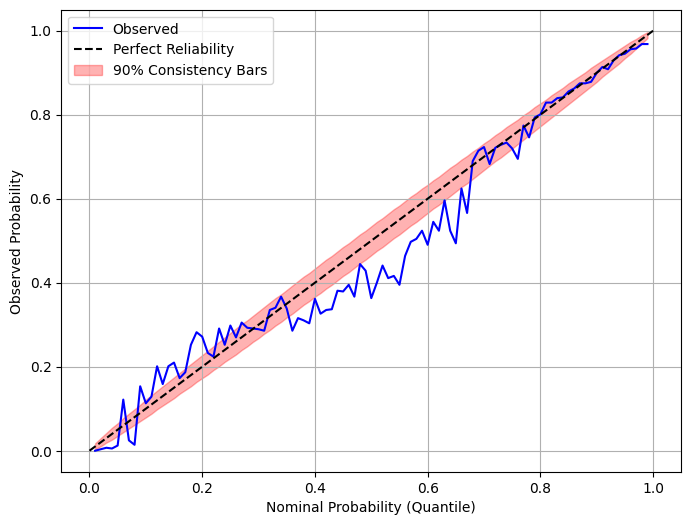

In [12]:
# Calculate the observed probabilities for each quantile
def compute_observed_probabilities(y_true, y_pred, quantiles):
    observed_probabilities = []
    for tau in quantiles:
        # For each quantile, compute the proportion of observed values <= the predicted value
        observed_prob = np.mean(y_true <= y_pred[tau], axis=0)
        observed_probabilities.append(observed_prob)
    return np.array(observed_probabilities)

# Function to compute consistency bars
def compute_consistency_bars(quantiles, n_samples, confidence_level=0.90):
    lower_bounds = []
    upper_bounds = []
    alpha = 1 - confidence_level
    for q in quantiles:
        # Use binomial distribution to calculate bounds
        lower = binom.ppf(alpha / 2, n_samples, q) / n_samples
        upper = binom.ppf(1 - alpha / 2, n_samples, q) / n_samples
        lower_bounds.append(lower)
        upper_bounds.append(upper)
    return np.array(lower_bounds), np.array(upper_bounds)

# Example data (replace with your actual data)
n_samples = len(y_test)  # Number of samples in the test set

observed_probabilities = compute_observed_probabilities(y_test, pred_test, quantiles)

# Compute consistency bars
lower_bounds, upper_bounds = compute_consistency_bars(quantiles, n_samples)

# Plot reliability diagram with consistency bars
plt.figure(figsize=(8, 6))
plt.plot(quantiles, observed_probabilities, label='Observed', color='b')
plt.plot([0, 1], [0, 1], label='Perfect Reliability', linestyle='--', color='k')
plt.fill_between(quantiles, lower_bounds, upper_bounds, color='red', alpha=0.3, label='90% Consistency Bars')
plt.xlabel('Nominal Probability (Quantile)')
plt.ylabel('Observed Probability')

plt.legend()
plt.grid(True)
plt.show()
